In [2]:
import re
import os
import nltk
import string
import datetime
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.metrics import Metric
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.layers import Embedding, LSTM, Dense, Dropout
from google_drive_downloader import GoogleDriveDownloader as gdd




In [3]:
tf.compat.v1.enable_eager_execution()

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
# tf.compat.v1.disable_eager_execution()
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.33.254.234:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.33.254.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.254.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
tf.compat.v1.disable_eager_execution()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/softcom final/Dataset 1.csv', encoding = "ISO-8859-1")
df.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [9]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))
nltk.download('punkt')
puncset = list(string.punctuation)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
def preprocessed(text):
  sentence = [lemmatizer.lemmatize(i, pos='v') for i in text.split() if i not in puncset and i not in english_stops]
  sentence = [w for w in sentence if w.isalpha()]
  return ' '.join(sentence)

In [11]:
df['message'] = df.message.map(lambda x: preprocessed(x))

In [ ]:
df.message

0                                           real good miss
1                                               read manga
2                                                         
3          Need send accountant I even refer Those support
4                                                ADD ME ON
                               ...                        
10309    No Depression G Herbo mood do stress people de...
10310    What depression succumb brain make feel like n...
10311    Ketamine Nasal Spray Shows Promise Against Sui...
10312                        dont mistake bad day everyone
10313                                                     
Name: message, Length: 10314, dtype: object

In [12]:
sentence_length = []
count = Counter()
for i in df.message:
  temp = i.split()
  sentence_length.append(len(temp))
  for j in temp:
    count[j] += 1

In [13]:
num_words = len(count)
max_length = max(sentence_length)
print('Number Of Words: ',num_words)
print('Maximum Length of Sentence: ',max_length)
print('Dataset Length : ', df.shape[0])

Number Of Words:  12883
Maximum Length of Sentence:  43
Dataset Length :  10314


In [14]:
from sklearn.model_selection import train_test_split

train_text,test_text,train_label,test_label = train_test_split(df['message'], df['label'], stratify=df['label'],test_size=0.20,random_state=1)

In [15]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['message'])
word_index = tokenizer.word_index

In [16]:
train_text = tokenizer.texts_to_sequences(train_text)
test_text = tokenizer.texts_to_sequences(test_text)

In [17]:
train_padding = pad_sequences(
    train_text, maxlen=max_length, padding='post', truncating='post'
)
test_padding = pad_sequences(
    test_text, maxlen=max_length, padding='post', truncating='post'
)

In [18]:
print(len(train_padding))
print(len(test_padding))

8251
2063


In [19]:
lr = 0.001

In [20]:
max_features =80000
embedding_dim = 128
sequence_length = max_length

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(1024,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               
model.add(tf.keras.layers.Conv1D(512,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 
model.add(tf.keras.layers.Conv1D(256,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))

In [21]:
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives','accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 128)           10240128  
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 1024)          394240    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 512)           1573376   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 256)           393472    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

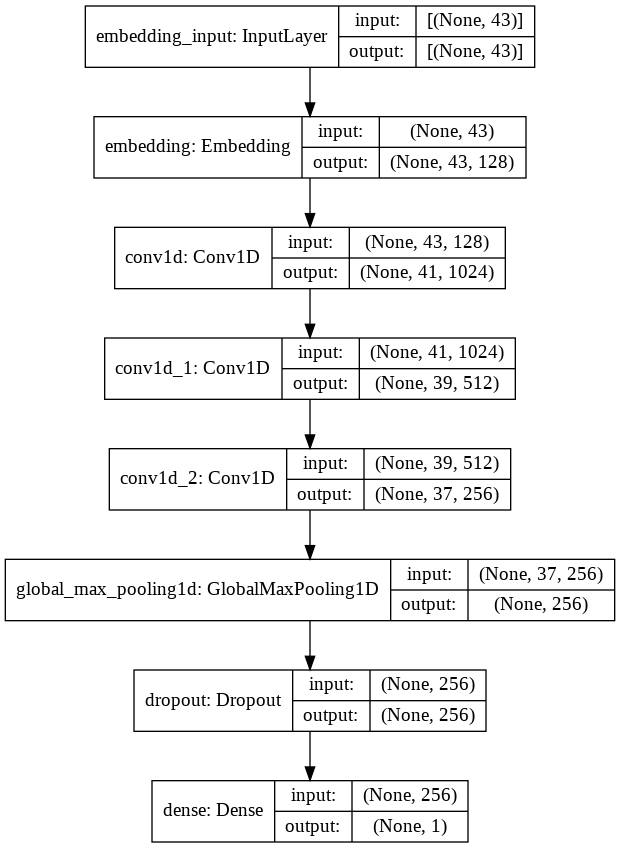

In [22]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [23]:
epochs = 10
batch = 200
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_padding, train_label, epochs=epochs, verbose=1,
                    batch_size=batch,
                    validation_data = (test_padding,test_label))

Train on 8251 samples, validate on 2063 samples
Epoch 1/10
8251/8251 [==============================] - ETA: 0s - loss: 2.2781 - TruePositives: 76.0000 - TrueNegatives: 6295.0000 - FalsePositives: 105.0000 - FalseNegatives: 1775.0000 - accuracy: 0.7721 - precision: 0.4199 - recall: 0.0411

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8251/8251 [==============================] - 127s 15ms/sample - loss: 2.2781 - TruePositives: 76.0000 - TrueNegatives: 6295.0000 - FalsePositives: 105.0000 - FalseNegatives: 1775.0000 - accuracy: 0.7721 - precision: 0.4199 - recall: 0.0411 - val_loss: 0.5170 - val_TruePositives: 233.0000 - val_TrueNegatives: 1600.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 230.0000 - val_accuracy: 0.8885 - val_precision: 1.0000 - val_recall: 0.5032
Epoch 2/10
8251/8251 [==============================] - 126s 15ms/sample - loss: 0.3185 - TruePositives: 1474.0000 - TrueNegatives: 6320.0000 - FalsePositives: 80.0000 - FalseNegatives: 377.0000 - accuracy: 0.9446 - precision: 0.9485 - recall: 0.7963 - val_loss: 0.2541 - val_TruePositives: 364.0000 - val_TrueNegatives: 1594.0000 - val_FalsePositives: 6.0000 - val_FalseNegatives: 99.0000 - val_accuracy: 0.9491 - val_precision: 0.9838 - val_recall: 0.7862
Epoch 3/10
8251/8251 [==============================] - 125s 15ms/sample - loss: 0.1806 - 

In [24]:
f1_score = []
for p,r in zip(history.history['precision'], history.history['recall']):
  temp = 2 * ((p*r) + (p+r))
  f1_score.append(temp)
epoch = [x for x in range(epochs+1)]

f1_score_val = []
for p,r in zip(history.history['val_precision'], history.history['val_recall']):
  temp = 2 * ((p*r) + (p+r))
  f1_score_val.append(temp)

In [25]:

f1_score_df = pd.DataFrame()
f1_score_df = pd.DataFrame(columns = ['Epoch','F1 Score'])
f1_score_df['Epoch'] = pd.Series(epoch)
f1_score_df['F1 Score'] = pd.Series(f1_score)

f1_score_df_val = pd.DataFrame()
f1_score_df_val = pd.DataFrame(columns = ['Epoch','F1 Score'])
f1_score_df_val['Epoch'] = pd.Series(epoch)
f1_score_df_val['F1 Score'] = pd.Series(f1_score_val)



Text(0.5, 0, 'Epochs')

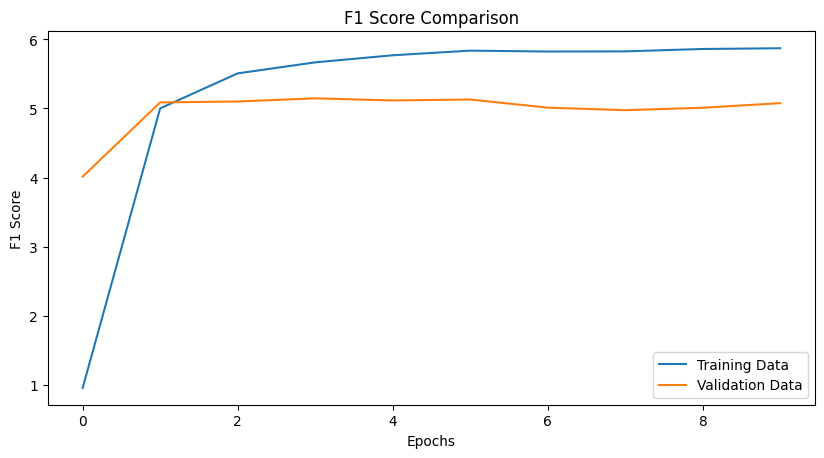

In [26]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(f1_score_df['Epoch'], f1_score_df['F1 Score'],label="Training Data")
plt.plot(f1_score_df['Epoch'], f1_score_df_val['F1 Score'],label="Validation Data")
plt.title('F1 Score Comparison')
plt.legend(loc="lower right")
plt.ylabel('F1 Score')
plt.xlabel('Epochs')



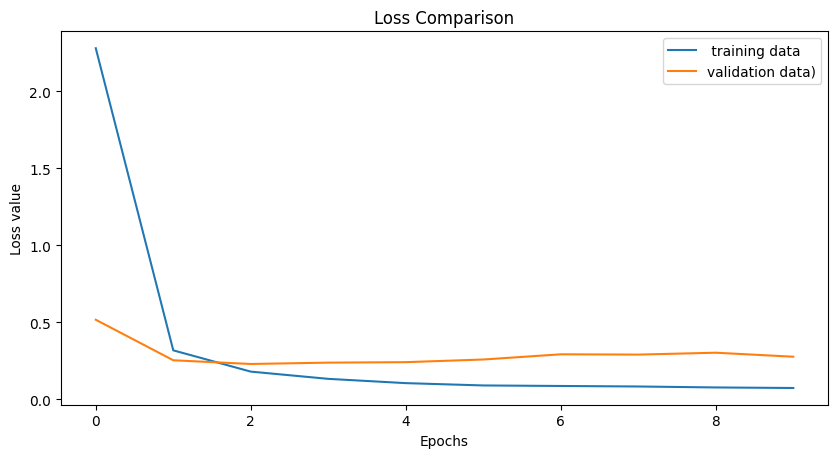

In [27]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss Comparison')
plt.ylabel('Loss value')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

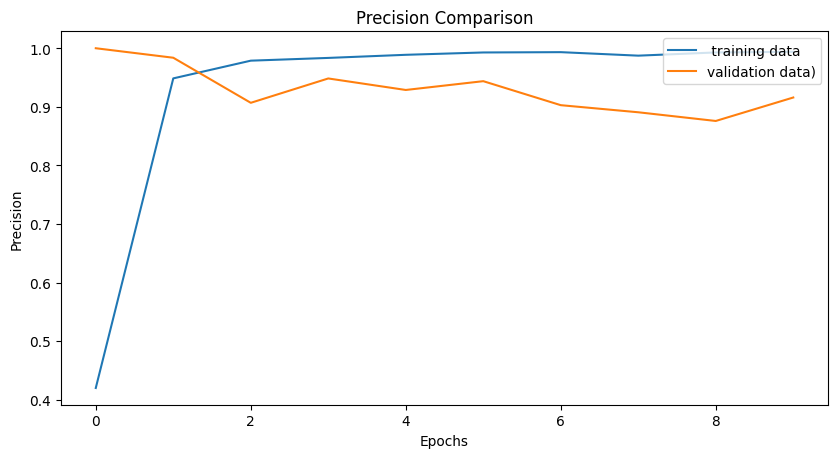

In [28]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(history.history['precision'], label=' training data')
plt.plot(history.history['val_precision'], label='validation data)')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

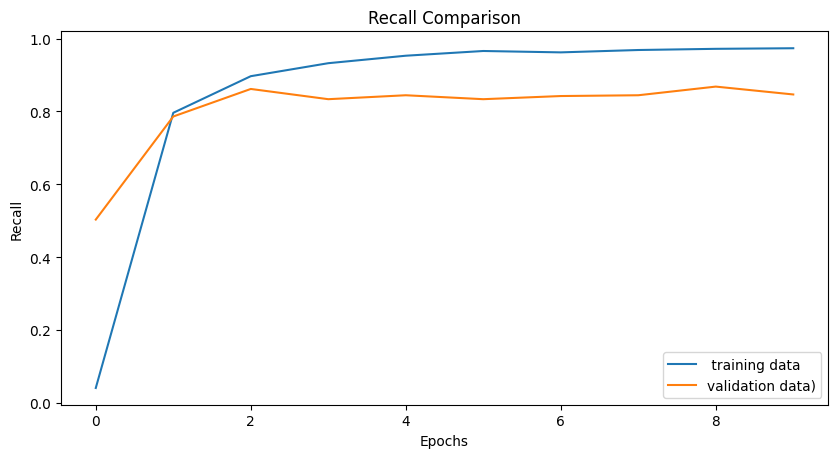

In [29]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(history.history['recall'], label=' training data')
plt.plot(history.history['val_recall'], label='validation data)')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()

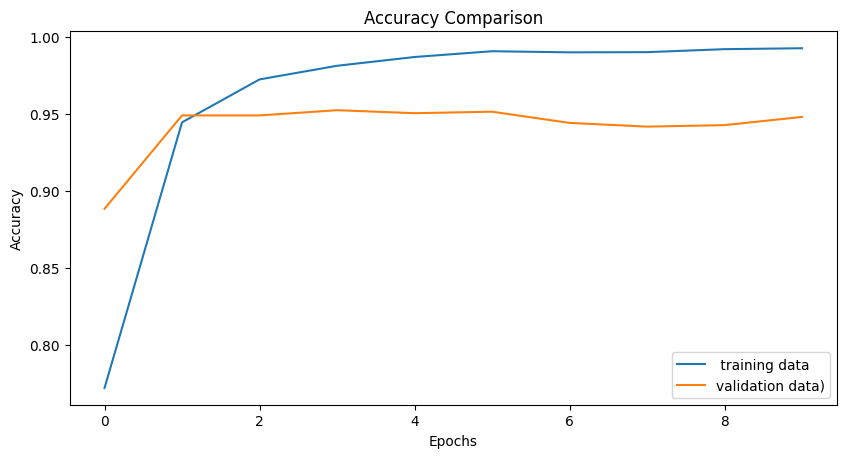

In [30]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99
plt.plot(history.history['accuracy'], label=' training data')
plt.plot(history.history['val_accuracy'], label='validation data)')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()

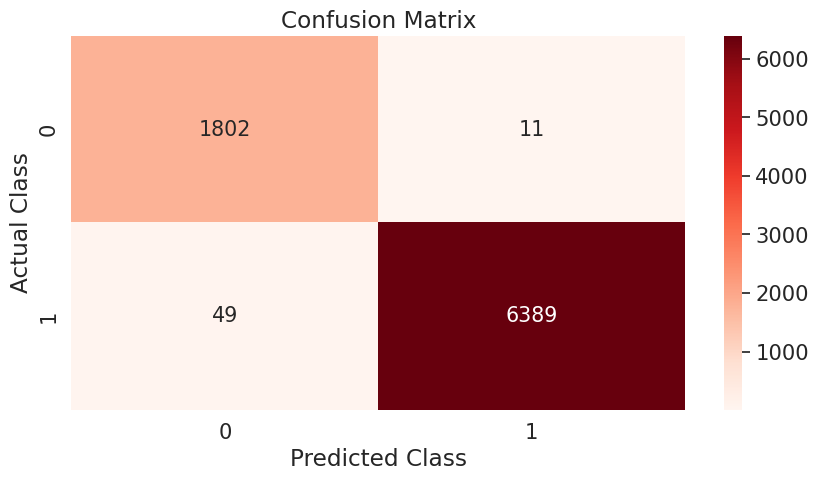

In [31]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['figure.dpi'] = 99

array = [[history.history['TruePositives'][-1],history.history['FalsePositives'][-1]],
         [history.history['FalseNegatives'][-1],history.history['TrueNegatives'][-1]]]
df_cm = pd.DataFrame(array, range(2), range(2))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},cmap='Reds', fmt='g') 
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('Confusion_Matrix.png')
plt.show()

In [32]:
def predict_sentiment(text):

  text = tokenizer.texts_to_sequences(text)
  test_vector = pad_sequences(
    text, maxlen = max_length, padding='post', truncating='post'
  )
  
  # print(model.predict(test_vector))
  predictions = model.predict(test_vector)
  predictions = list(predictions.flatten())
  for prediction,txt in zip(predictions,test_text):
    if prediction>0.5:
      print()
      print(txt)
      print(" ---------- > (1)  Negative Message")
    else:
      print()
      print(txt)
      print(" ---------- >(0)   Positive Message ")

  

In [37]:
test_text = ["The dog is too lazy and stupid." , 
             "You did  marvelous job.", 
             "I am very depressed these days. I don't enjoy anything.",
             "What a magnificent game it was,just wonderful."]

predict_sentiment(test_text)






The dog is too lazy and stupid.
 ---------- > (1)  Negative Message

You did  marvelous job.
 ---------- > (0)  Positive Message

I am very depressed these days. I don't enjoy anything.
 ---------- > (1)  Negative Message

What a magnificent game it was,just wonderful.
 ---------- > (0)  Positive Message


In [38]:
model.save('cnn_model.h1')

INFO:tensorflow:Assets written to: cnn_model.h1/assets


INFO:tensorflow:Assets written to: cnn_model.h1/assets
